In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/ColabProjects/DGM_Project_2025')
import sys
sys.path.append(os.getcwd())

In [3]:
!pip install tabpfn
!pip install "tabpfn-extensions[all] @ git+https://github.com/PriorLabs/tabpfn-extensions.git"

  Created wheel for tabpfn-extensions: filename=tabpfn_extensions-0.2.1-py3-none-any.whl size=112484 sha256=c70846e61858f123bf668f30fc8b5024351fded4152823be152973ee5d8b7200
  Stored in directory: /tmp/pip-ephem-wheel-cache-75zct8_l/wheels/69/98/f3/b735f53edb7ee7262fde13260f95e628eae639fa9c9bc1cfa8
Successfully built tabpfn-extensions


In [4]:
import numpy as np
#import process_edited as pce
import process_GQ as pce
import autoencoder as ae
import diffusion as diff
import TabDDPMdiff as TabDiff
import pandas as pd
import torch
import os
import time
from tabpfn_extensions.embedding import TabPFNEmbedding
from tabpfn import TabPFNClassifier, TabPFNRegressor
import random
from torch.optim import Adam

In [6]:
# --- Global Switch ---
# Set to True to use TabPFN for embeddings, False for the original Auto-Encoder
USE_TABPFN_EMBEDDINGS = True

# --- General Hyperparameters ---
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
threshold = 0.01
# AE Hyperparams (used for both AE and as layer sizes for the new TabPFNDecoder)
hidden_size = 250
num_layers = 3
lr = 2e-4
weight_decay = 1e-6
n_epochs_ae = 10000
batch_size_ae = 50
# Decoder Hyperparams (New for TabPFN)
decoder_lr = 1e-4
decoder_n_epochs = 15000
decoder_batch_size = 64


# ==============================================================================
# 2. MAIN LOOP
# ==============================================================================

strings_set = {'abalone', 'adult', 'Churn_Modelling', 'faults', 'indian_liver_patient',
               'insurance', 'News', 'Obesity', 'Shoppers', 'Titanic', 'wilt', 'Bean', 'nursery', 'Magic', 'HTRU'}
Model = 'AutoDiff'

#for string in strings_set:
string='abalone'
# Use the correct file path after mounting Google Drive
filename = f'Real_Data/{string}.csv'

print(f"\n################################################################################")
print(f"Processing Dataset: {string}")

try:
  real_df = pd.read_csv(filename)
except FileNotFoundError:
  print(f"ERROR: File not found at {filename}. Skipping.")
  #continue

# --- 2A. Pre-processing (Common to both approaches) ---
parser = pce.DataFrameParser().fit(real_df, threshold)

# Data tensor is the target for the *TabPFNDecoder*
data_tensor_np = parser.transform()
data_tensor = torch.tensor(data_tensor_np, dtype=torch.float32).to(device)

# Get metadata for the Decoder output layer
datatype_info = parser.datatype_info()
n_bins = datatype_info['n_bins']; n_cats = datatype_info['n_cats']
n_nums = datatype_info['n_nums']; cards = datatype_info['cards']

latent_features = None

# --- 2B. LATENT FEATURE EXTRACTION SWITCH ---
if USE_TABPFN_EMBEDDINGS:
  print("--- Mode: TabPFN Embeddings ---")

  # 1. Prepare raw data for TabPFN's API
  X_train = real_df.copy()
  # Create a dummy target 'y' (Required by TabPFN's API)
  y_train = np.zeros(len(X_train))

  # 2. Extract TabPFN Embeddings (This is the new Encoder)
  clf = TabPFNClassifier(random_state=SEED, device=device, ignore_pretraining_limits=True)
  clf.fit(X_train, y_train)

  embedder = TabPFNEmbedding(tabpfn_clf=clf, n_fold=5)
  embeddings_np = embedder.get_embeddings(X_train, y_train, X_train,data_source="test")

  if embeddings_np.ndim == 3:
      embeddings_np = embeddings_np.mean(axis=0)

  latent_features = torch.tensor(embeddings_np, dtype=torch.float32).to(device)
  print(f"TabPFN Embeddings (latent_features) Shape: {latent_features.shape}")

  # 3. Train the New Decoder (Crucial for reversing the process later)
  print("Training TabPFNDecoder...")
  embedding_size = latent_features.shape[1]

  decoder_model = ae.TabPFNDecoder(embedding_size, n_bins, n_cats, n_nums, cards,
                                hidden_size=hidden_size, num_layers=num_layers)
  decoder_model.to(device)
  decoder_optimizer = Adam(decoder_model.parameters(), lr=decoder_lr)

  # Training loop for the TabPFN Decoder
  for epoch in range(decoder_n_epochs):
      # Sample a batch of indices
      batch_indices = random.sample(range(len(latent_features)), decoder_batch_size)
      batch_embeddings = latent_features[batch_indices]
      batch_data = data_tensor[batch_indices] # Target: Processed data

      reconstructed_data = decoder_model(batch_embeddings)

      # Use the existing auto_loss function
      loss = ae.auto_loss(batch_data, reconstructed_data, n_bins, n_nums, n_cats, cards)

      decoder_optimizer.zero_grad()
      loss.backward()
      decoder_optimizer.step()

      if (epoch + 1) % (decoder_n_epochs // 10) == 0:
            print(f"Decoder Epoch {epoch+1}/{decoder_n_epochs}, Loss: {loss.item():.4f}")

  # Save the trained TabPFN Decoder
  torch.save(decoder_model.state_dict(), f'{string}_tabpfn_decoder.pth')
  print("TabPFNDecoder training complete.")

else:
  print("--- Mode: Original Auto-Encoder ---")

  # 2. Train Original Auto-encoder and extract latent features
  ds = ae.train_autoencoder(real_df, hidden_size, num_layers, lr, weight_decay, n_epochs_ae, batch_size_ae, threshold)
  latent_features = ds[1].detach().to(device)
  print(f"AE Latent Features Shape: {latent_features.shape}")

# --- 2C. DIFFUSION MODEL TRAINING (Universal Step) ---

# Diffusion Hyper-parameters (from your original code)
diff_n_epochs = 2000
hidden_dims = (256, 512, 1024, 512, 256)
converted_table_dim = latent_features.shape[1] # Dimension matches the chosen latent feature set
sigma = 20
num_batches_per_epoch = 50
T = 100
eps = 1e-5
maximum_learning_rate = 1e-2

print("\nStarting Diffusion Model Training...")
score = TabDiff.train_diffusion(latent_features, T, eps, sigma, lr, \
                  num_batches_per_epoch, maximum_learning_rate, weight_decay, diff_n_epochs, batch_size_ae)
print(f"Diffusion Training Complete for {string}.")



################################################################################
Processing Dataset: abalone
--- Mode: TabPFN Embeddings ---


tabpfn-v2.5-classifier-v2.5_default.ckpt:   0%|          | 0.00/42.9M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

TabPFN Embeddings (latent_features) Shape: torch.Size([4177, 192])
Training TabPFNDecoder...
Decoder Epoch 1500/15000, Loss: 2.8353
Decoder Epoch 3000/15000, Loss: 2.2346
Decoder Epoch 4500/15000, Loss: 1.7383
Decoder Epoch 6000/15000, Loss: 1.6753
Decoder Epoch 7500/15000, Loss: 1.5215
Decoder Epoch 9000/15000, Loss: 1.3066
Decoder Epoch 10500/15000, Loss: 1.2379
Decoder Epoch 12000/15000, Loss: 1.1432
Decoder Epoch 13500/15000, Loss: 1.1772
Decoder Epoch 15000/15000, Loss: 1.2744
TabPFNDecoder training complete.

Starting Diffusion Model Training...


  0%|          | 0/2000 [00:00<?, ?it/s]

/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:270: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=x.device)
/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


Diffusion Training Complete for abalone.


Starting generation loop with forced CPU decoding...


  0%|          | 0/100 [00:00<?, ?it/s]

/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:256: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=x.device)
/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/100 [00:00<?, ?it/s]

/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:256: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=x.device)
/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/100 [00:00<?, ?it/s]

/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:256: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=x.device)
/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/100 [00:00<?, ?it/s]

/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:256: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=x.device)
/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/100 [00:00<?, ?it/s]

/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:256: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=x.device)
/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/100 [00:00<?, ?it/s]

/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:256: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=x.device)
/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/100 [00:00<?, ?it/s]

/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:256: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=x.device)
/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/100 [00:00<?, ?it/s]

/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:256: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=x.device)
/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/100 [00:00<?, ?it/s]

/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:256: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=x.device)
/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/100 [00:00<?, ?it/s]

/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:256: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=x.device)
/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


Sampling times saved to /content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/Synthetic_Data/AutoDiff/abalone/AutoDiff_abalone_sampling_time.csv

Starting Plotting...
Plot saved as rings_distribution_comparison.png


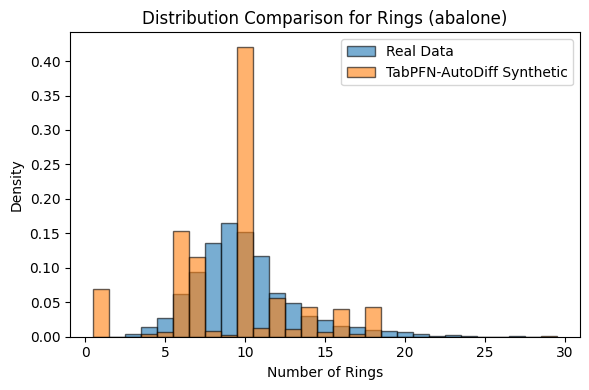

In [7]:
import time
import os
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

string = 'abalone'
Model = 'AutoDiff'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

score.to(device)

decoder_model.to('cpu')
decoder_model.eval()

T = 100
N = latent_features.shape[0]
P = latent_features.shape[1]

time_duration = []
synthetic_dfs = []
output_directory = os.getcwd()+f'/Synthetic_Data/{Model}/{string}/'


def simple_inverse_transform(decoded_data_tensor, parser):

    datatype_info = parser.datatype_info()
    n_bins = datatype_info['n_bins']; n_cats = datatype_info['n_cats']
    n_nums = datatype_info['n_nums']; cards = datatype_info['cards']

    gen_output = {}
    current_idx = 0

    if n_nums > 0:
        gen_output['nums'] = decoded_data_tensor[:, current_idx : current_idx + n_nums]
        current_idx += n_nums

    if n_bins > 0:
        gen_output['bins'] = decoded_data_tensor[:, current_idx : current_idx + n_bins]
        current_idx += n_bins

    if n_cats > 0:
        cat_tensors_list = []
        for card in cards:
            cat_tensors_list.append(decoded_data_tensor[:, current_idx : current_idx + card])
            current_idx += card
        gen_output['cats'] = cat_tensors_list

    syn_df = pce.convert_to_table(real_df, gen_output, threshold)

    return syn_df

# ==============================================================================
# 3. GENERATION LOOP
# ==============================================================================
print("Starting generation loop with forced CPU decoding...")
for i in range(1, 11):
    start_time = time.time()

    # 1. Diffusion Sampling (Output 'sample' is on CUDA)
    sample = TabDiff.Euler_Maruyama_sampling(score, T, N, P, device)

    # 2. Decoding
    with torch.no_grad():
        sample_cpu = sample.cpu()

        decoded_data_tensor = decoder_model(sample_cpu)

    # 3. Post-processing and Inverse Transformation
    syn_df = simple_inverse_transform(decoded_data_tensor, parser)

    end_time = time.time()
    duration = end_time - start_time
    time_duration.append(duration)
    synthetic_dfs.append(syn_df)

    # 4. Save the Synthetic Data
    filename_i = f'{Model}_{string}{i}.csv'
    output_file = os.path.join(output_directory, filename_i)
    syn_df.to_csv(output_file, index=False)

# 5. Save Sampling Times
sampling_time = f'{Model}_{string}_sampling_time.csv'
time_file = os.path.join(output_directory, sampling_time)
df_time = pd.DataFrame(time_duration, columns=[f'{Model}_{string}_sampling_time'])
df_time.to_csv(time_file, index=False)
print(f"Sampling times saved to {time_file}")

# ==============================================================================
# 6. PLOTTING THE FIRST SAMPLE
# ==============================================================================

print("\nStarting Plotting...")
syn_df_plot = synthetic_dfs[0]
col = 'Rings'

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

min_val = min(real_df[col].min(), syn_df_plot[col].min())
max_val = max(real_df[col].max(), syn_df_plot[col].max())
bins = np.arange(int(min_val), int(max_val) + 2) - 0.5

axes.hist(real_df[col], bins=bins, alpha=0.6, label='Real Data', edgecolor='black', density=True)
axes.hist(syn_df_plot[col], bins=bins, alpha=0.6, label='TabPFN-AutoDiff Synthetic', edgecolor='black', density=True)

axes.set_title(f'Distribution Comparison for {col} (abalone)')
axes.set_xlabel('Number of Rings')
axes.set_ylabel('Density')
axes.legend()

plt.tight_layout()
plt.savefig('rings_distribution_comparison.png')
print("Plot saved as rings_distribution_comparison.png")

In [8]:
# ==============================================
# Train AE ON EMBEDDINGS (use embeddings as input, built-in AE training/loss)
# Produces:
#   ds = (decoder_fn, latent_features, num_min_values, num_max_values)
#   latent_features = AE bottleneck z (from embeddings)
# ==============================================
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
threshold = 0.01
# AE Hyperparams (used for both AE and as layer sizes for the new TabPFNDecoder)
hidden_size = 250
num_layers = 3
lr = 2e-4
weight_decay = 1e-6
n_epochs_ae = 10000
batch_size_ae = 50
# Decoder Hyperparams (New for TabPFN)
decoder_lr = 1e-4
decoder_n_epochs = 15000
decoder_batch_size = 64


# ==============================================================================
# 2. MAIN LOOP
# ==============================================================================

Model = 'AutoDiff'

string='abalone'
filename = f'Real_Data/{string}.csv'

print(f"\n################################################################################")
print(f"Processing Dataset: {string}")

try:
  real_df = pd.read_csv(filename)
except FileNotFoundError:
  print(f"ERROR: File not found at {filename}. Skipping.")


parser = pce.DataFrameParser().fit(real_df, threshold)

data_tensor_np = parser.transform()
data_tensor = torch.tensor(data_tensor_np, dtype=torch.float32).to(device)


datatype_info = parser.datatype_info()
n_bins = datatype_info['n_bins']; n_cats = datatype_info['n_cats']
n_nums = datatype_info['n_nums']; cards = datatype_info['cards']

X_train = real_df.copy()

y_train = np.zeros(len(X_train))

clf = TabPFNClassifier(random_state=SEED, device=device, ignore_pretraining_limits=True)
clf.fit(X_train, y_train)

embedder = TabPFNEmbedding(tabpfn_clf=clf, n_fold=5)
embeddings_np = embedder.get_embeddings(X_train, y_train, X_train,data_source="test")

if embeddings_np.ndim == 3:
    embeddings_np = embeddings_np.mean(axis=0)

latent_features = torch.tensor(embeddings_np, dtype=torch.float32).to(device)

tabpfn_embeddings = latent_features.detach()
embed_dim = tabpfn_embeddings.shape[1]


ae_model = ae.DeapStack(
    n_bins, n_cats, n_nums, cards,
    in_features=data_tensor.shape[1],
    hidden_size=hidden_size,
    bottleneck_size=embed_dim,
    num_layers=max(num_layers, 3)
).to(device)

# --------------------------
# Training hyperparameters
# --------------------------
ALIGN_ONLY_EPOCHS   = 5000      # Stage A
JOINT_EPOCHS        = 5000      # Stage B
ALIGN_BATCH_SIZE    = max(64, decoder_batch_size)
JOINT_BATCH_SIZE    = max(64, batch_size_ae)
LAMBDA_ALIGN        = 1
LAMBDA_RECON        = 0.000       # weight for AE recon loss
AE_LR               = 1e-3
AE_WD               = 1e-6

mse = torch.nn.MSELoss()
ae_opt = Adam(ae_model.parameters(), lr=AE_LR, weight_decay=AE_WD)

N = data_tensor.shape[0]
idx_all = np.arange(N)

def _mini_batch_indices(n, bs):
    choice = np.random.choice(n, size=min(bs, n), replace=False)
    return torch.as_tensor(choice, device=device)

# --------------------------
# Stage A: Encoder alignment
# --------------------------
print("Stage A: aligning AE bottleneck to TabPFN embeddings...")
for step in range(ALIGN_ONLY_EPOCHS):
    idx = _mini_batch_indices(N, ALIGN_BATCH_SIZE)
    x_batch = data_tensor[idx]
    e_batch = tabpfn_embeddings[idx]
    z_batch = ae_model.featurize(x_batch)

    loss_align = mse(z_batch, e_batch)
    ae_opt.zero_grad()
    loss_align.backward()
    ae_opt.step()

    if (step + 1) % max(1, ALIGN_ONLY_EPOCHS // 10) == 0:
        print(f"[Align {step+1}/{ALIGN_ONLY_EPOCHS}] MSE(z,e) = {loss_align.item():.6f}")


def _dict_outputs_to_flat(out_dict, n_bins, cards, n_nums):
    """
    Convert {'bins': (B,n_bins), 'cats': [ (B,card1),... ], 'nums': (B,n_nums)}
    into a single (B, n_bins + sum(cards) + n_nums) tensor.
    """
    parts = []
    if n_bins > 0:
        parts.append(out_dict['bins'])  # (B, n_bins)
    if len(cards) > 0:
        # concat list of (B, card_i) along feature dim
        parts.append(torch.cat(out_dict['cats'], dim=1))  # (B, sum(cards))
    if n_nums > 0:
        parts.append(out_dict['nums'])  # (B, n_nums)
    return torch.cat(parts, dim=1) if len(parts) else None

# ----------------------------------------------------------
# Stage B: Joint training (reconstruction + alignment term)
# ----------------------------------------------------------
print("Stage B: joint training (reconstruction + alignment)...")
for step in range(JOINT_EPOCHS):
    idx = _mini_batch_indices(N, JOINT_BATCH_SIZE)
    x_batch = data_tensor[idx]
    e_batch = tabpfn_embeddings[idx]

    outputs_dict = ae_model(x_batch)                    # dict: 'bins','cats','nums'
    outputs_flat = _dict_outputs_to_flat(outputs_dict, n_bins, cards, n_nums)  # (B, total_dim)
    z_batch = ae_model.featurize(x_batch)


    loss_recon = ae.auto_loss(x_batch, outputs_flat, n_bins, n_nums, n_cats, cards)

    loss_align  = mse(z_batch, e_batch)
    loss_total  = LAMBDA_RECON * loss_recon + LAMBDA_ALIGN * loss_align

    ae_opt.zero_grad()
    loss_total.backward()
    ae_opt.step()

    if (step + 1) % max(1, JOINT_EPOCHS // 10) == 0:
        print(f"[Joint {step+1}/{JOINT_EPOCHS}] "
              f"Recon={loss_recon.item():.6f}  Align={loss_align.item():.6f}  Total={loss_total.item():.6f}")


with torch.no_grad():
    latent_list = []
    BS = 2048
    for i in range(0, N, BS):
        latent_list.append(ae_model.featurize(data_tensor[i:i+BS]))
    latent_features = torch.cat(latent_list, dim=0)     # (N, embed_dim)

print(f"AE Latent (aligned to TabPFN) Shape: {tuple(latent_features.shape)}")




################################################################################
Processing Dataset: abalone
Stage A: aligning AE bottleneck to TabPFN embeddings...
[Align 500/5000] MSE(z,e) = 0.001540
[Align 1000/5000] MSE(z,e) = 0.001430
[Align 1500/5000] MSE(z,e) = 0.000892
[Align 2000/5000] MSE(z,e) = 0.000774
[Align 2500/5000] MSE(z,e) = 0.000696
[Align 3000/5000] MSE(z,e) = 0.000604
[Align 3500/5000] MSE(z,e) = 0.000618
[Align 4000/5000] MSE(z,e) = 0.000566
[Align 4500/5000] MSE(z,e) = 0.000483
[Align 5000/5000] MSE(z,e) = 0.000460
Stage B: joint training (reconstruction + alignment)...
[Joint 500/5000] Recon=6.190531  Align=0.000586  Total=0.000586
[Joint 1000/5000] Recon=5.881401  Align=0.000653  Total=0.000653
[Joint 1500/5000] Recon=5.886649  Align=0.000495  Total=0.000495
[Joint 2000/5000] Recon=5.759230  Align=0.000446  Total=0.000446
[Joint 2500/5000] Recon=5.924507  Align=0.000379  Total=0.000379
[Joint 3000/5000] Recon=6.139873  Align=0.000426  Total=0.000426
[Joint 350

In [9]:
# ===============================
# Decoder + Diffusion + Sampling
# ===============================
import os, time
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def _dict_outputs_to_flat(out_dict, n_bins, cards, n_nums):
    parts = []
    if n_bins > 0:
        parts.append(out_dict['bins'])
    if len(cards) > 0:
        parts.append(torch.cat(out_dict['cats'], dim=1))
    if n_nums > 0:
        parts.append(out_dict['nums'])
    return torch.cat(parts, dim=1) if parts else None

embedding_size = latent_features.shape[1]
decoder_model = ae.TabPFNDecoder(embedding_size, n_bins, n_cats, n_nums, cards,
                                hidden_size=hidden_size, num_layers=num_layers)
decoder_model.to(device)
decoder_optimizer = Adam(decoder_model.parameters(), lr=decoder_lr)

for epoch in range(decoder_n_epochs):
    batch_indices = random.sample(range(len(latent_features)), decoder_batch_size)
    batch_embeddings = latent_features[batch_indices]
    batch_data = data_tensor[batch_indices]
    reconstructed_data = decoder_model(batch_embeddings)

    loss = ae.auto_loss(batch_data, reconstructed_data, n_bins, n_nums, n_cats, cards)

    decoder_optimizer.zero_grad()
    loss.backward()
    decoder_optimizer.step()

    if (epoch + 1) % (decoder_n_epochs // 10) == 0:
          print(f"Decoder Epoch {epoch+1}/{decoder_n_epochs}, Loss: {loss.item():.4f}")

num_start = n_bins + sum(cards)
num_end   = num_start + n_nums
_data_proc_t = torch.tensor(parser.transform(), dtype=torch.float32, device=device)
num_min_values, _ = torch.min(_data_proc_t[:, num_start:num_end], dim=0) if n_nums > 0 else (None, None)
num_max_values, _ = torch.max(_data_proc_t[:, num_start:num_end], dim=0) if n_nums > 0 else (None, None)

@torch.no_grad()
def decode_to_table(z_latent: torch.Tensor):
    """
    z_latent: (B, latent_dim) on any device
    Returns: pandas.DataFrame (synthetic table) using pce.convert_to_table on dict outputs.
    """
    z_latent = z_latent.to(next(decoder_model.parameters()).device)
    out_dict = decoder_model.decoder(z_latent, num_min_values, num_max_values)
    syn_df = pce.convert_to_table(real_df, out_dict, threshold)
    return syn_df

# ===========================
# 2C. Diffusion: train score
# ===========================
diff_n_epochs          = 10000
hidden_dims            = (256, 512, 1024, 512, 256)
converted_table_dim    = latent_features.shape[1]
sigma                  = 20
num_batches_per_epoch  = 50
T                      = 200
eps                    = 1e-5
maximum_learning_rate  = 1e-2
lr                     = lr

print("\nStarting Diffusion Model Training...")
score = TabDiff.train_diffusion(
    latent_features, T, eps, sigma, lr,
    num_batches_per_epoch, maximum_learning_rate,
    weight_decay, diff_n_epochs, batch_size_ae
)
print(f"Diffusion Training Complete for {string}.")


Decoder Epoch 1500/15000, Loss: 2.7256
Decoder Epoch 3000/15000, Loss: 1.9957
Decoder Epoch 4500/15000, Loss: 1.4812
Decoder Epoch 6000/15000, Loss: 1.4090
Decoder Epoch 7500/15000, Loss: 1.2401
Decoder Epoch 9000/15000, Loss: 1.0603
Decoder Epoch 10500/15000, Loss: 0.9515
Decoder Epoch 12000/15000, Loss: 0.8401
Decoder Epoch 13500/15000, Loss: 0.8908
Decoder Epoch 15000/15000, Loss: 0.8604

Starting Diffusion Model Training...


  0%|          | 0/10000 [00:00<?, ?it/s]

/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:270: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=x.device)
/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


Diffusion Training Complete for abalone.


Starting generation loop with forced CPU decoding...


  0%|          | 0/300 [00:00<?, ?it/s]

/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:256: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=x.device)
/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


[1/30] Saved synthetic dataset → /content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/Synthetic_Data/AutoDiff/abalone/AutoDiff_abalone1.csv


  0%|          | 0/300 [00:00<?, ?it/s]

/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:256: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=x.device)
/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


[2/30] Saved synthetic dataset → /content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/Synthetic_Data/AutoDiff/abalone/AutoDiff_abalone2.csv


  0%|          | 0/300 [00:00<?, ?it/s]

/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:256: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=x.device)
/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


[3/30] Saved synthetic dataset → /content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/Synthetic_Data/AutoDiff/abalone/AutoDiff_abalone3.csv


  0%|          | 0/300 [00:00<?, ?it/s]

/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:256: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=x.device)
/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


[4/30] Saved synthetic dataset → /content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/Synthetic_Data/AutoDiff/abalone/AutoDiff_abalone4.csv


  0%|          | 0/300 [00:00<?, ?it/s]

/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:256: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=x.device)
/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


[5/30] Saved synthetic dataset → /content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/Synthetic_Data/AutoDiff/abalone/AutoDiff_abalone5.csv


  0%|          | 0/300 [00:00<?, ?it/s]

/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:256: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=x.device)
/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


[6/30] Saved synthetic dataset → /content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/Synthetic_Data/AutoDiff/abalone/AutoDiff_abalone6.csv


  0%|          | 0/300 [00:00<?, ?it/s]

/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:256: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=x.device)
/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


[7/30] Saved synthetic dataset → /content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/Synthetic_Data/AutoDiff/abalone/AutoDiff_abalone7.csv


  0%|          | 0/300 [00:00<?, ?it/s]

/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:256: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=x.device)
/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


[8/30] Saved synthetic dataset → /content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/Synthetic_Data/AutoDiff/abalone/AutoDiff_abalone8.csv


  0%|          | 0/300 [00:00<?, ?it/s]

/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:256: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=x.device)
/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


[9/30] Saved synthetic dataset → /content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/Synthetic_Data/AutoDiff/abalone/AutoDiff_abalone9.csv


  0%|          | 0/300 [00:00<?, ?it/s]

/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:256: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=x.device)
/content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/TabDDPMdiff.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


[10/30] Saved synthetic dataset → /content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/Synthetic_Data/AutoDiff/abalone/AutoDiff_abalone10.csv

Sampling times saved → /content/drive/MyDrive/ColabProjects/AutoDiffusion/Codes + Descriptions/Synthetic_Data/AutoDiff/abalone/AutoDiff_abalone_sampling_time.csv

Plotting a quick distribution comparison...


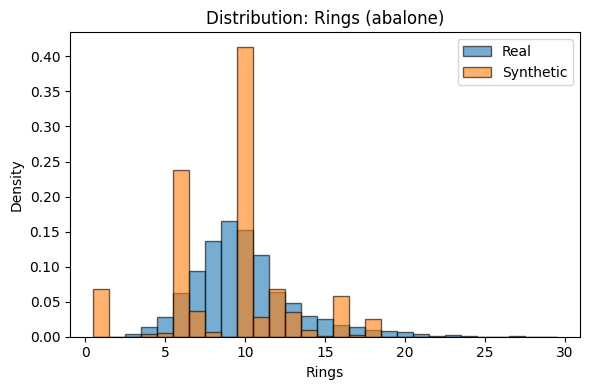

Done.


In [11]:

# ======================
# Sampling / Generation
# ======================
def simple_inverse_transform(decoded_data_tensor, parser):

    datatype_info = parser.datatype_info()
    n_bins = datatype_info['n_bins']; n_cats = datatype_info['n_cats']
    n_nums = datatype_info['n_nums']; cards = datatype_info['cards']

    gen_output = {}
    current_idx = 0

    if n_nums > 0:
        gen_output['nums'] = decoded_data_tensor[:, current_idx : current_idx + n_nums]
        current_idx += n_nums

    if n_bins > 0:
        gen_output['bins'] = decoded_data_tensor[:, current_idx : current_idx + n_bins]
        current_idx += n_bins

    if n_cats > 0:
        cat_tensors_list = []
        for card in cards:
            cat_tensors_list.append(decoded_data_tensor[:, current_idx : current_idx + card])
            current_idx += card
        gen_output['cats'] = cat_tensors_list

    syn_df = pce.convert_to_table(real_df, gen_output, threshold)

    return syn_df


decoder_model.to('cpu').eval()


N_gen = latent_features.shape[0]
P     = latent_features.shape[1]
T = 300

output_directory = os.path.join(os.getcwd(), f'Synthetic_Data/{Model}/{string}')
os.makedirs(output_directory, exist_ok=True)

synthetic_dfs = []
time_duration = []

# ==============================================================================
# 3. GENERATION LOOP
# ==============================================================================
print("Starting generation loop with forced CPU decoding...")
for i in range(1, 11):
    start_time = time.time()
    z_sample = TabDiff.Euler_Maruyama_sampling(score, T, N, P, device)

    with torch.no_grad():
        z_sample_cpu = z_sample.cpu()
        decoded_data_tensor = decoder_model(z_sample_cpu)

    syn_df = simple_inverse_transform(decoded_data_tensor, parser)


    end_time = time.time()
    time_duration.append(end_time - start_time)
    synthetic_dfs.append(syn_df)

    out_file = os.path.join(output_directory, f'{Model}_{string}{i}.csv')
    syn_df.to_csv(out_file, index=False)

    print(f"[{i}/30] Saved synthetic dataset → {out_file}")

time_df = pd.DataFrame(time_duration, columns=[f'{Model}_{string}_sampling_time'])
time_file = os.path.join(output_directory, f'{Model}_{string}_sampling_time.csv')
time_df.to_csv(time_file, index=False)
print(f"\nSampling times saved → {time_file}")

print("\nPlotting a quick distribution comparison...")
syn_df_plot = synthetic_dfs[0]

col = 'Rings' if 'Rings' in real_df.columns else real_df.columns[0]  # fallback if not in dataset

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
try:
    min_val = min(real_df[col].min(), syn_df_plot[col].min())
    max_val = max(real_df[col].max(), syn_df_plot[col].max())
    bins = np.arange(int(min_val), int(max_val) + 2) - 0.5
except Exception:
    bins = 30

ax.hist(real_df[col], bins=bins, alpha=0.6, label='Real', edgecolor='black', density=True)
ax.hist(syn_df_plot[col], bins=bins, alpha=0.6, label='Synthetic', edgecolor='black', density=True)
ax.set_title(f'Distribution: {col} ({string})')
ax.set_xlabel(col); ax.set_ylabel('Density'); ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_directory, f'{string}_{col}_distribution.png'), dpi=150)
plt.show()
print("Done.")
